<h1> XGBoost algorithm Jupyter notebook </h1>

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning.

<h3> Load python packages </h3>


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import shap

<h3> Load the datasets </h3>
<b> Note: </b> For now this notebook assumes the input data (X) and the output variable (y) are in the same txt file. We will use a second step to build the X matrix and y vector as input to our model.

<h4> Specify the path of the file </h4>

In [2]:
path_to_file=''

In [3]:
data_set=pd.read_csv(path_to_file,sep=',')

<h4> Check if the data is loaded correcty </h4>

In [4]:
data_set.head()

,Condition,ImageNumber,AreaShape_Area,AreaShape_BoundingBoxArea,AreaShape_BoundingBoxMaximum_X,AreaShape_BoundingBoxMaximum_Y,AreaShape_BoundingBoxMinimum_X,AreaShape_BoundingBoxMinimum_Y,AreaShape_Center_X,AreaShape_Center_Y,...,AreaShape_MinFeretDiameter,AreaShape_MinorAxisLength,AreaShape_Orientation,AreaShape_Perimeter,AreaShape_Solidity,Location_Center_X,Location_Center_Y,Location_Center_Z,Number_Object_Number,Parent_Nuclei
0,NC,13,1498,4131,371,87,320,6,347.143525,44.004005,...,26.095121,22.956607,22.534677,236.622366,0.752008,347.143525,44.004005,0,1,1
1,NC,13,5769,13736,652,136,551,0,601.668053,72.405963,...,68.308755,59.043138,-32.701535,845.033621,0.721576,601.668053,72.405963,0,2,2
2,NC,13,1219,2975,562,117,477,82,521.388023,101.620181,...,28.008654,21.905340,-81.027292,243.858910,0.577999,521.388023,101.620181,0,3,3
3,NC,13,1332,3100,388,130,326,80,359.172673,101.122372,...,36.572532,33.137725,62.379434,248.178716,0.750000,359.172673,101.122372,0,4,4
4,NC,13,2278,6300,184,207,121,107,157.235733,137.693591,...,54.288579,51.787400,32.251644,440.090404,0.591996,157.235733,137.693591,0,5,5


<h3> Check the column names and remove irrelevant CellProfiler output </h3>

In [5]:
data_set.columns

Index(['Condition', 'ImageNumber', 'AreaShape_Area',
       'AreaShape_BoundingBoxArea', 'AreaShape_BoundingBoxMaximum_X',
       'AreaShape_BoundingBoxMaximum_Y', 'AreaShape_BoundingBoxMinimum_X',
       'AreaShape_BoundingBoxMinimum_Y', 'AreaShape_Center_X',
       'AreaShape_Center_Y', 'AreaShape_Compactness', 'AreaShape_ConvexArea',
       'AreaShape_Eccentricity', 'AreaShape_EquivalentDiameter',
       'AreaShape_EulerNumber', 'AreaShape_Extent', 'AreaShape_FormFactor',
       'AreaShape_MajorAxisLength', 'AreaShape_MaxFeretDiameter',
       'AreaShape_MaximumRadius', 'AreaShape_MeanRadius',
       'AreaShape_MedianRadius', 'AreaShape_MinFeretDiameter',
       'AreaShape_MinorAxisLength', 'AreaShape_Orientation',
       'AreaShape_Perimeter', 'AreaShape_Solidity', 'Location_Center_X',
       'Location_Center_Y', 'Location_Center_Z', 'Number_Object_Number',
       'Parent_Nuclei'],
      dtype='object')

In [6]:
X_input=data_set.drop(['Condition','ImageNumber','Location_Center_X','Location_Center_Y','Location_Center_Z','Number_Object_Number','Parent_Nuclei'],axis=1)

In [7]:
y_vector=data_set['Condition']

<h4> auto encode the labels (needed for XGBoost algorithm)

In [22]:
encoder=preprocessing.LabelEncoder()

In [26]:
encoded_conditions=encoder.fit_transform(y_vector)

In [27]:
print(encoded_conditions)

[0 0 0 ... 1 1 1]


<h3> XGBoost classifier </h3>

<h5> Split the data into train and test sets </h5>

In [28]:
X_train,X_test,y_train,y_test=train_test_split(X_input,encoded_conditions,train_size=0.7,random_state=42)

In [29]:
print('Shape of train and test data is:')
X_train.shape, X_test.shape

Shape of train and test data is:


((762, 25), (327, 25))

In [35]:
print(y_train.__len__())

762


<h4> Tune the parameters of the XGBoost model </h4>

In [30]:
import xgboost as xgb

In [31]:
xgb_classifier = xgb.XGBClassifier()

In [32]:
searchParameters = {
            'min_child_weight': [0.1, 1, 5, 10, 50],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [5, 10, 25, 50],
            'learning_rate': [0.0001, 0.001, 0.1, 1],
            'n_estimators': [50, 100, 250, 500],
            'reg_alpha': [0.0001, 0.001, 0.1, 1],
            'reg_lambda': [0.0001, 0.001, 0.1, 1]
                    }

fitingParameters={
            "early_stopping_rounds":10,
            "eval_metric" : "auc", 
            "eval_set" : [[X_train, y_train]]
                   }

random_search = RandomizedSearchCV(
                xgb_classifier, 
                cv=5,
                param_distributions=searchParameters, 
                scoring='roc_auc', 
                n_jobs=-1,
                verbose=10, 
                random_state=0,
                        )

searchModel=random_search.fit(X_train, y_train, **fitingParameters)
bestParameters=searchModel.best_estimator_.get_params()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    6.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    6.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.0s finished


[0]	validation_0-auc:0.81167
[1]	validation_0-auc:0.84250
[2]	validation_0-auc:0.85868
[3]	validation_0-auc:0.86065
[4]	validation_0-auc:0.87545
[5]	validation_0-auc:0.88398
[6]	validation_0-auc:0.89768
[7]	validation_0-auc:0.90181
[8]	validation_0-auc:0.91024
[9]	validation_0-auc:0.91575
[10]	validation_0-auc:0.91887
[11]	validation_0-auc:0.92176
[12]	validation_0-auc:0.92803
[13]	validation_0-auc:0.93118
[14]	validation_0-auc:0.93434
[15]	validation_0-auc:0.93903
[16]	validation_0-auc:0.94164
[17]	validation_0-auc:0.94634
[18]	validation_0-auc:0.94752
[19]	validation_0-auc:0.95030
[20]	validation_0-auc:0.95309
[21]	validation_0-auc:0.95632
[22]	validation_0-auc:0.96249
[23]	validation_0-auc:0.96402
[24]	validation_0-auc:0.96535
[25]	validation_0-auc:0.96713
[26]	validation_0-auc:0.96915
[27]	validation_0-auc:0.97130
[28]	validation_0-auc:0.97380
[29]	validation_0-auc:0.97437
[30]	validation_0-auc:0.97766


C:\Users\tkuijpe1\Anaconda3\envs\TopoChipScreen\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[31]	validation_0-auc:0.97983
[32]	validation_0-auc:0.98064
[33]	validation_0-auc:0.98279
[34]	validation_0-auc:0.98409
[35]	validation_0-auc:0.98519
[36]	validation_0-auc:0.98603
[37]	validation_0-auc:0.98717
[38]	validation_0-auc:0.98887
[39]	validation_0-auc:0.98959
[40]	validation_0-auc:0.98996
[41]	validation_0-auc:0.99100
[42]	validation_0-auc:0.99199
[43]	validation_0-auc:0.99226
[44]	validation_0-auc:0.99269
[45]	validation_0-auc:0.99358
[46]	validation_0-auc:0.99400
[47]	validation_0-auc:0.99398
[48]	validation_0-auc:0.99459
[49]	validation_0-auc:0.99491
[50]	validation_0-auc:0.99499
[51]	validation_0-auc:0.99553
[52]	validation_0-auc:0.99603
[53]	validation_0-auc:0.99641
[54]	validation_0-auc:0.99657
[55]	validation_0-auc:0.99714
[56]	validation_0-auc:0.99754
[57]	validation_0-auc:0.99779
[58]	validation_0-auc:0.99797
[59]	validation_0-auc:0.99801
[60]	validation_0-auc:0.99810
[61]	validation_0-auc:0.99818
[62]	validation_0-auc:0.99820
[63]	validation_0-auc:0.99856
[64]	valid

<h4> Select the best parameters and use in the XGBoost classifier to test the model's performance </h4>

In [33]:
xgb_model=xgb.XGBClassifier(**bestParameters)

<h4> Train the model with the best parameter settings </h4>

In [36]:
xgb_model.fit(X_train,y_train)

[13:27:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, gamma=1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=None)

<h4> make predictions for the test data to investigate model accuracy </h4>

In [37]:
y_predictions=xgb_model.predict(X_test)

In [38]:
predictions=[round(value) for value in y_predictions]

In [42]:
accuracy= accuracy_score(y_test,predictions)

In [43]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 63.91%


<h4> Plot the most important features based on the SHAP values </h4>

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). 

In [45]:
explainer=shap.Explainer(xgb_model)

In [46]:
shap_values=explainer(X_input)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


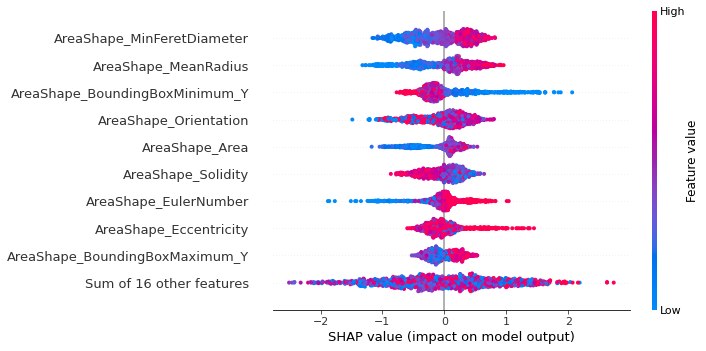

In [48]:
shap.plots.beeswarm(shap_values)